In [246]:
from time import sleep
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from collections import Counter,defaultdict
import igraph as ig

In [251]:
from time import sleep
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup


class Connector():
    def __init__(self):
        """Конструктор класса Connector. Инициализирует переменные экземпляра класса.
        """
        self.url = 'https://scholar.google.ru'
        self.userAgent = 'Mozilla/5.0 (X11; Linux x86_64; rv:27.0) Gecko/20100101 Firefox/27.0'
        self.res_mass = []  # Результаты поиска
        self.pars_mass = []  # Ссылки для парсинга
        self.history = []  # История посещений

    def parser(self, part_url):
        """Метод для парсинга страницы Google Scholar с помощью BeautifulSoup. 

        Args:
            part_url (str): часть URL-адреса страницы, которую необходимо распарсить. 

        Returns:
            BeautifulSoup: Возвращает объект BeautifulSoup
        """
        req = Request(url=self.url+part_url,
                      headers={'User-Agent': self.userAgent})
        with urlopen(req) as response:
            html_content = response.read()
        soup = BeautifulSoup(html_content, 'html.parser')
        return soup

    def start(self, collaber_link, max_deep=0):
        """Метод для запуска парсинга. 

        Args:
            collaber_link (str): Cсылкf на страницу Google Scholar автора, чьи совместные работы мы ищем
            max_deep (int, optional): Указывает на максимальный уровень вложенности для поиска. 
            По умолчанию max_deep равен 0, что означает, что парсинг будет происходить только на странице автора.
            Метод запускает поиск совместных работ и заполняет список res_mass результатами.
        """
        soup = self.parser('/citations?hl=ru&user=tMY31_gAAAAJ')
        name = soup.find('div', attrs={'id': 'gsc_prf_in'}).text
        company = soup.find('div', attrs={'class': 'gsc_prf_il'}).text
        collaber_main_link = (name, company, collaber_link, 0)
        self.pars_mass.append(collaber_main_link)
        self.deep = collaber_main_link[3]
        self.pars(max_deep)

    def pars(self, max_deep):
        """Метод для поиска совместных работ на страницах Google Scholar сотрудников. 

        Args:
            max_deep (int): максимальный уровень вложенности для поиска. 
            Если уровень вложенности достигнут, поиск прекращается. 
            Метод использует список pars_mass для хранения ссылок на страницы сотрудников,
            которые необходимо распарсить.
        """
        while self.pars_mass:  # Пока в списке есть ссылки для парсинга
            collaber_main_link = self.pars_mass.pop(
                0)  # Берем первую ссылку из списка
            # Если достигнут максимальный уровень вложенности
            if collaber_main_link[3] > max_deep:
                print('Парсинг завершен')
                break
            # Если ссылка уже была посещена
            if collaber_main_link[0] in self.history:
                continue
            self.history.append(collaber_main_link[0])
            resp = self.parser(collaber_main_link[2])
            print('pars', collaber_main_link)
            sleep(2)
            self.find_collabers(
                resp, collaber_main_link[:2], collaber_main_link[3])

    def find_collabers(self, resp, collaber_main, current_deep):
        """Метод для поиска совместных работ на странице Google Scholar сотрудника. 
        Метод добавляет результаты в список res_mass и ссылки для парсинга в список pars_mass.

        Args:
            resp (BeautifulSoup): _description_
            collaber_main (tuple): Данные об авторе, чьи совместные работы ищутся
            current_deep (_type_): Указывает на текущий уровень вложенности поиска.
        """
        for colaber in resp.findAll('span', class_="gsc_rsb_a_desc"):
            link = colaber.find('a')['href']
            name = colaber.find('a').text
            company = colaber.find('span', class_='gsc_rsb_a_ext').text
            colab = (*collaber_main, name, company)
            # Добавляем результат в список результатов
            self.res_mass.append(colab)
            # Добавляем новую ссылку в список для парсинга
            self.pars_mass.append((name, company, link, current_deep+1))
        self.deep = current_deep


def format(text):
    """Функция форматирования для обьединения компаний 
        принимает строку, в которой происходит поиск слов из словаря.
    Args:
        text (str): строка, в которой происходит поиск слов из словаря

    Returns:
        str: возвращает отформатированную строку
    """
    company_dict = {"Google": "Google",
                    "Microsoft": "Microsoft",
                    "Facebook": "Facebook",
                    "Tencent": "Tencent",
                    "Citadel": "Citadel",
                    "University of Edinburgh": "University of Edinburgh",
                    "Koko": "Koko",
                    "Northwestern polytechnical university": "Northwestern polytechnical university",
                    "IBM": "IBM",
                    "University of Texas at Dallas": "University of Texas at Dallas",
                    "nVidia Research": "nVidia Research",
                    "Shanghai Jiao Tong University": "Shanghai Jiao Tong University",
                    "Tsinghua University": "Tsinghua University",
                    "Idiap Research Institute": "Idiap Research Institute",
                    "Adobe": "Adobe",
                    "NetEase": "NetEase",
                    "DeepMind": "DeepMind",
                    "Sony": "Sony",
                    "Amazon": "Amazon",
                    "Alibaba": "Alibaba",
                    "IEEE Fellow": "IEEE Fellow",
                    "Alibaba": "Alibaba",
                    "Zoom": "Zoom",
                    "Apple": "Apple",
                    "Stanford University": "Stanford University",
                    "Hong Kong": "Hong Kong Polytechnic University",
                    "university of Washington": "University of Washington",
                    "Peking": "Peking University",
                    "Duke": "Duke University",
                    "Toronto": "Toronto University",
                    "Cambridge": "Cambridge University",
                    "Meta": "Meta AI",
                    "University of Rochester": "University of Rochester",
                    "Johns Hopkins University": "Johns Hopkins University",
                    "JD.COM": "JD.COM",
                    "CITI, Academia Sinica": "CITI, Academia Sinica",
                    "Georgia Tech": "Georgia Tech",
                    "Georgia Institute": "Georgia Institute",
                    "Carnegie mellon": "Carnegie mellon",
                    "University of British Columbia": "University of British Columbia",
                    }

    if text == '':
        return('not found')
    for company in company_dict:
        if company.lower() in text.lower():
            return company_dict[company]
    return text


def filter_data_for_graph(unfiltred_data):
    data = []
    companies = []  # Список компаний, удовлетворяющих условию
    authors = []  # Список авторов, удовлетворяющих условию
    for item in unfiltred_data:
        text_1 = format(item[1])
        text_2 = format(item[3])
        data.append((item[0], text_1, item[2], text_2))

    # Подсчитываем количество вхождений компаний
    company_counts = Counter([x[2] for x in data])

    # Фильтруем компании, удовлетворяющие условию
    for company, count in company_counts.items():
        if count >= 10:
            companies.append(company)

    # Фильтруем кортежи, удовлетворяющие заданным условиям
    filtered_data = [x for x in data if x[2] in companies and x[3]
                     != 'not found' and x[1] != 'not found']

    # Подсчитываем количество вхождений авторов
    author_counts = Counter([x[1] for x in filtered_data])

    # Фильтруем авторов, удовлетворяющих условию
    for author, count in author_counts.items():
        if count >= 10:
            authors.append(author)

    # Фильтруем кортежи, удовлетворяющие заданным условиям
    filtered_data = [x for x in filtered_data if x[1] in authors]

    return filtered_data




In [ ]:
link =('/citations?hl=ru&user=tMY31_gAAAAJ') 
Parser = Connector()
Parser.start(link,max_deep=1)

In [ ]:
coauthor_data = filter_data_for_graph(Parser.res_mass)

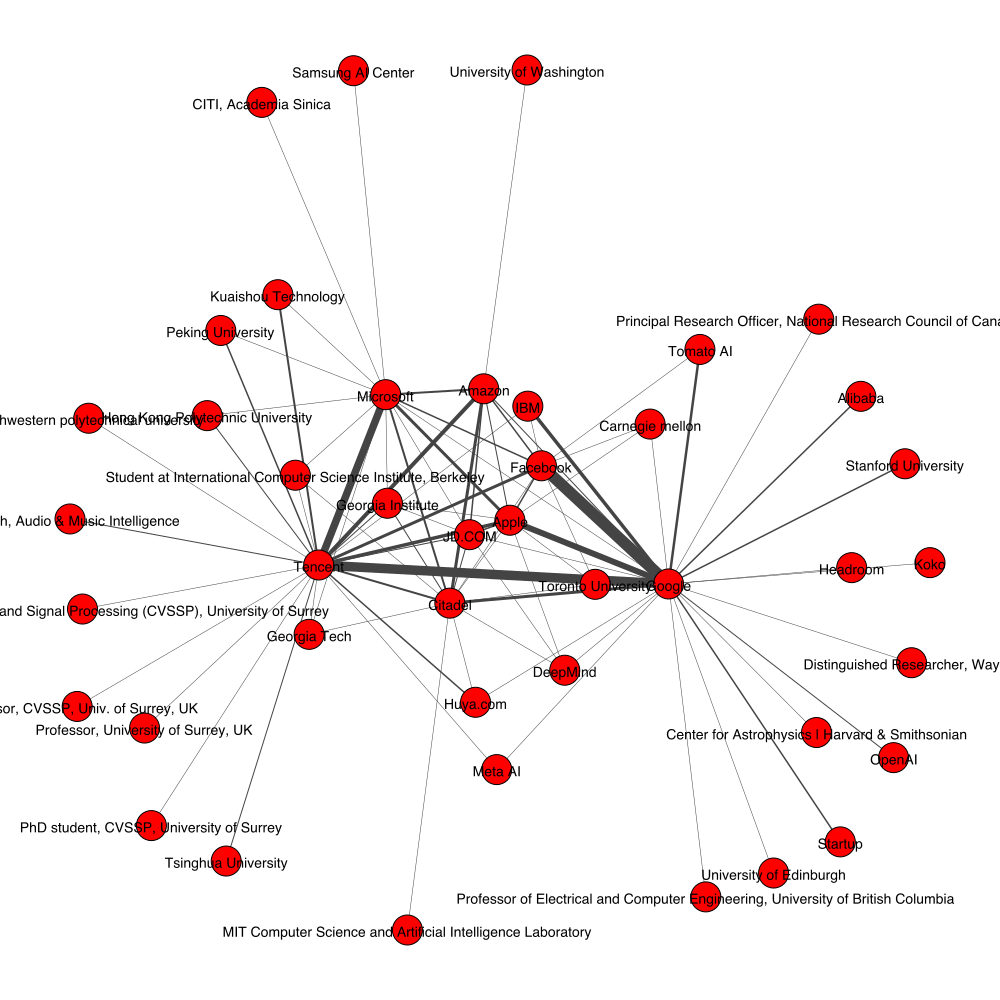

In [254]:
# Create a list of unique organizations and collaboration scores
orgs = list(set(org for _, org, _, _ in coauthor_data))
collab_scores = defaultdict(int)

# Calculate collaboration scores
for _, org1, _, org2 in coauthor_data:
    if org1 != org2:
        collab_scores[tuple(sorted((org1, org2)))] += 1

# Create an empty graph
G = ig.Graph()

# Add nodes to the graph
G.add_vertices(len(orgs))
# Set the node attributes (e.g., name)
G.vs['name'] = orgs

# Add edges based on collaboration scores
for org1, org2 in collab_scores.keys():
    org1_index = orgs.index(org1)
    org2_index = orgs.index(org2)

    G.add_edge(org1_index, org2_index, weight=collab_scores[(org1, org2)])

# Set the layout and visualize the graph
layout = G.layout('fruchterman_reingold')


ig.plot(G, layout=layout, vertex_size=30, bbox=(1000, 1000), margin=70,
        vertex_label=orgs, edge_width=[w / 2 for w in G.es['weight']])